![banner](https://learn.responsibly.ai/assets/img/banner.jpg)

# Class 6 - Transparency and Explainability

## 1. Setup

In [1]:
!wget http://stash.responsibly.ai/6-transparency/activity/GiveMeSomeCredit.zip -O GiveMeSomeCredit.zip -q
!unzip -q -o GiveMeSomeCredit.zip -d data

In [2]:
%pip install -qq numpy pandas xlrd matplotlib seaborn tabulate missingno sklearn imbalanced-learn statsmodels xlrd
%pip install -qq lime shap alibi aix360 corels
%pip install -qq git+https://github.com/MarcelRobeer/ContrastiveExplanation.git

     |████████████████████████████████| 275 kB 14.0 MB/s 
     |████████████████████████████████| 564 kB 44.6 MB/s 
     |████████████████████████████████| 398 kB 55.1 MB/s 
     |████████████████████████████████| 58.3 MB 1.7 MB/s 
     |████████████████████████████████| 105 kB 40.1 MB/s 
     |████████████████████████████████| 4.0 MB 45.7 MB/s 
     |████████████████████████████████| 28.0 MB 1.2 MB/s 
     |████████████████████████████████| 462 kB 58.7 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 26.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
     |████████████████████████████████| 275 kB 52.8 MB/s 
     |████████████████████████████████| 109.7 MB 8.8 kB/s 
     |████████████████████████████████| 264 kB 60.7 MB/s 
     |████████████████████████████████| 40 kB 6.6 MB/s 
     |████████████████████████████████| 10.7 MB 57.8 MB/s 
     |██████████

In [3]:
import os
from contextlib import (redirect_stdout, redirect_stderr,
                        contextmanager, ExitStack)
import warnings
warnings.filterwarnings('ignore')

from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve,
                             precision_recall_curve)
from sklearn.preprocessing import minmax_scale


# https://stackoverflow.com/questions/50691545/how-to-use-a-with-statement-to-suppress-sys-stdout-or-sys-stderr
@contextmanager
def suppress(out=True, err=True):
    with ExitStack() as stack:
        with open(os.devnull, 'w') as null:
            if out:
                stack.enter_context(redirect_stdout(null))
            if err:
                stack.enter_context(redirect_stderr(null))
            yield

## 2. Dataset

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

Source: [Kaggle - Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit)

### Columns

`SeriousDlqin2yrs` is the target. Read [here](https://www.investopedia.com/ask/answers/062315/what-are-differences-between-delinquency-and-default.asp) about delinquency.

In [4]:
!pip install "xlrd >= 1.2.0"

     |████████████████████████████████| 96 kB 5.6 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [5]:
display.HTML(pd.read_excel('data/Data Dictionary.xls', header=1).to_html())

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


### Loading data

In [6]:
df = pd.read_csv('data/cs-training.csv', index_col=0)

target_name = 'SeriousDlqin2yrs'
class_names = ['Good', 'Bad']

df[target_name] = df[target_name].astype(bool)

feature_names = np.array(df.columns.drop(target_name))

print('# Data:', len(df))
print('% Positive target:', df[target_name].mean() * 100)

# Data: 150000
% Positive target: 6.683999999999999


### Missing Data

⚠️ For the sake of simplicity, we will remove missing data **before** downsampling. In real-world scenario, the missing data might be important for deployment setting.

In [7]:
assert not df[target_name].isnull().any()

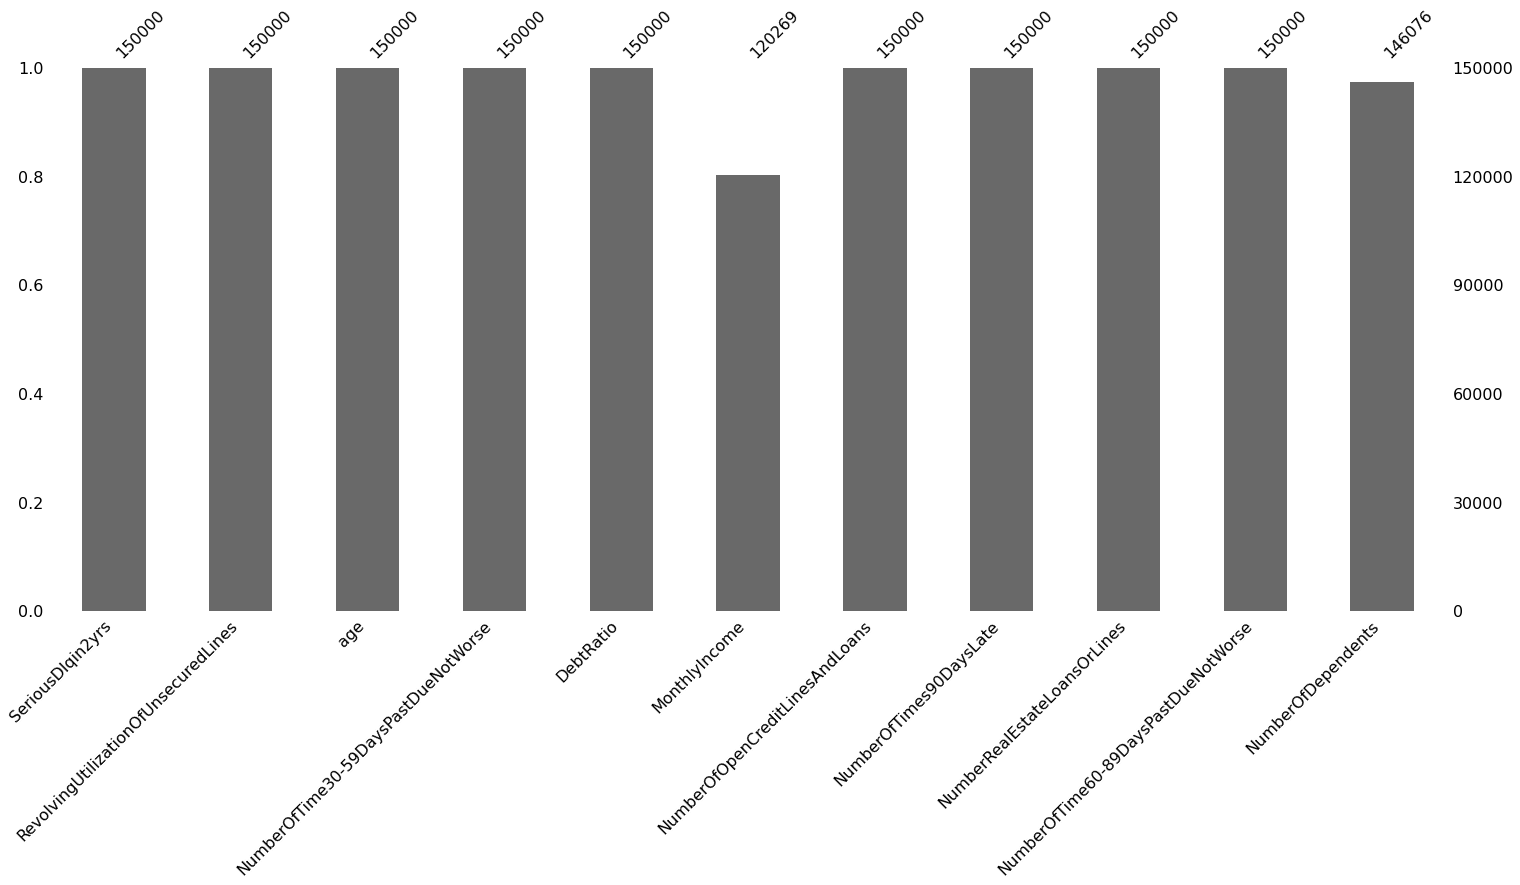

In [8]:
msno.bar(df);

In [9]:
dropna_df = df.dropna()

In [10]:
print('# Data:', len(dropna_df))
print('% Dropped NA / Original:', 100 * len(dropna_df) / len(df))
print('% Positive target:', dropna_df[target_name].mean() * 100)

# Data: 120269
% Dropped NA / Original: 80.17933333333333
% Positive target: 6.948590243537403


### Downsample majority class from ~95% to 70% to reduce imbalance

In [11]:
X, y = (RandomUnderSampler(sampling_strategy=1/3, random_state=42)
        .fit_resample(dropna_df.drop(target_name, axis=1), dropna_df[target_name]))

rus_df = pd.DataFrame(np.concatenate((X, y[:, None]), axis=1),
                      columns=list(feature_names) + [target_name])

print('# Data:', len(rus_df))
print('% Undersampled + Dropped NA / Original:', 100 * len(rus_df) / len(df))
print('% Positive target:', rus_df[target_name].mean() * 100)

# Data: 33428
% Undersampled + Dropped NA / Original: 22.285333333333334
% Positive target: 25.0


### Feature Engineering
Let's combine the three features that counts days past-due into one feature.

⚠️ This choise was done for the sake of simpliciy, and after some exploratory data analysis .

In [12]:
fe_df = rus_df.copy()

fe_df['NumberOfTimeDaysPastDue'] = (fe_df['NumberOfTime30-59DaysPastDueNotWorse']
                                    + fe_df['NumberOfTime60-89DaysPastDueNotWorse']
                                    + fe_df ['NumberOfTimes90DaysLate'])

fe_df = fe_df.drop(['NumberOfTime30-59DaysPastDueNotWorse',
                    'NumberOfTime60-89DaysPastDueNotWorse',
                    'NumberOfTimes90DaysLate'],
                     axis=1)

feature_names = np.array(fe_df.columns.drop(target_name))

# re-order columns that the target name is last
fe_df = fe_df[list(feature_names) + [target_name]]

### Splitting into training and test datasets

In [13]:
train_df, test_df = train_test_split(fe_df, test_size=0.3, random_state=42)

print('# Training dataset:', len(train_df))
print('# Test dataset:', len(test_df))

# Training dataset: 23399
# Test dataset: 10029


### Exploratory data analysis

#### Features

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23399 entries, 25688 to 15795
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  23399 non-null  float64
 1   age                                   23399 non-null  float64
 2   DebtRatio                             23399 non-null  float64
 3   MonthlyIncome                         23399 non-null  float64
 4   NumberOfOpenCreditLinesAndLoans       23399 non-null  float64
 5   NumberRealEstateLoansOrLines          23399 non-null  float64
 6   NumberOfDependents                    23399 non-null  float64
 7   NumberOfTimeDaysPastDue               23399 non-null  float64
 8   SeriousDlqin2yrs                      23399 non-null  float64
dtypes: float64(9)
memory usage: 1.8 MB


In [15]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,23399.0,5.614021,221.908494,0.0,0.047668,0.260911,0.766095,20514.0
age,23399.0,50.247019,14.281235,21.0,40.000000,49.000000,60.000000,101.0
DebtRatio,23399.0,22.519652,317.904623,0.0,0.146979,0.304763,0.506426,25801.0
MonthlyIncome,23399.0,6473.739604,8782.548092,0.0,3300.000000,5178.000000,8000.000000,699530.0
NumberOfOpenCreditLinesAndLoans,23399.0,8.673448,5.271255,0.0,5.000000,8.000000,11.000000,57.0
NumberRealEstateLoansOrLines,23399.0,1.059319,1.236426,0.0,0.000000,1.000000,2.000000,29.0
NumberOfDependents,23399.0,0.895209,1.163140,0.0,0.000000,0.000000,2.000000,8.0
NumberOfTimeDaysPastDue,23399.0,1.639130,16.534845,0.0,0.000000,0.000000,1.000000,294.0
SeriousDlqin2yrs,23399.0,0.248258,0.432012,0.0,0.000000,0.000000,0.000000,1.0


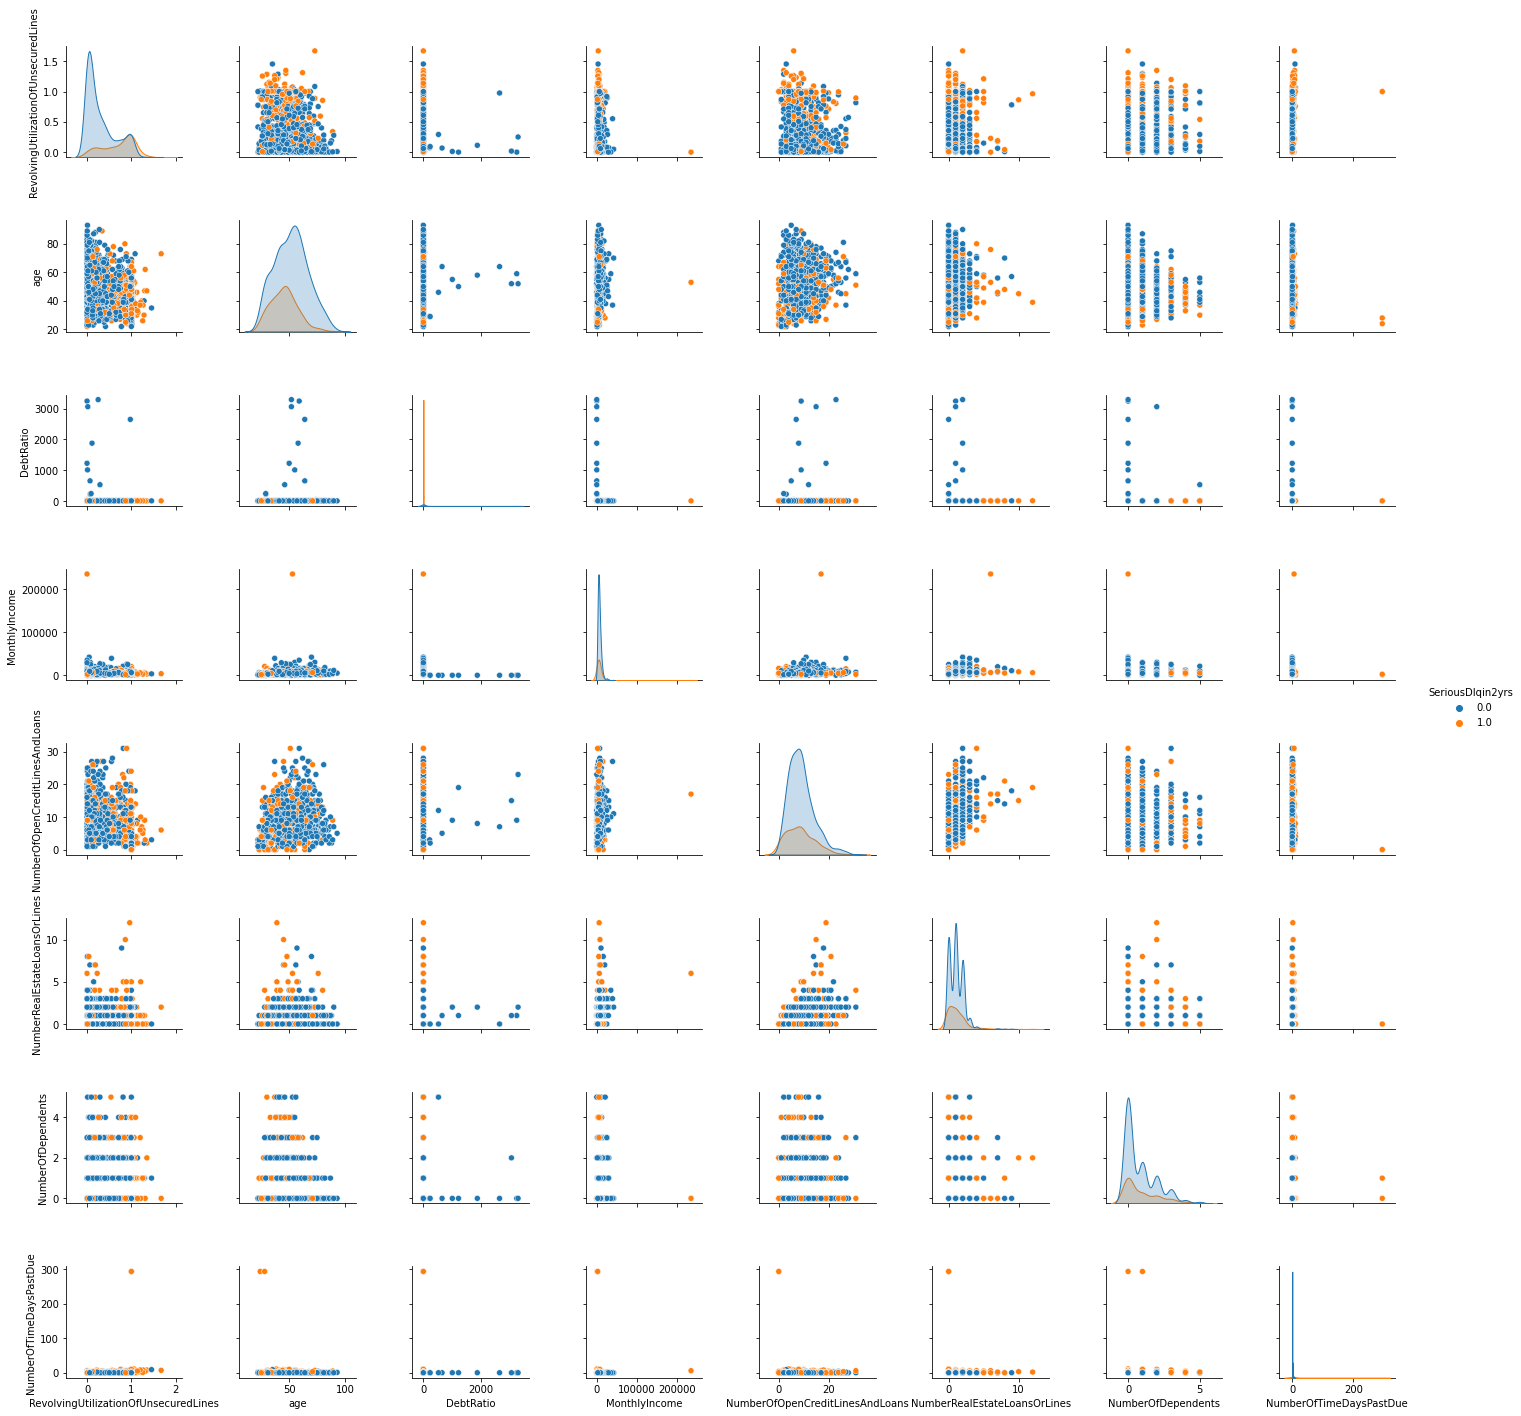

In [16]:
sns.pairplot(train_df.sample(1000), hue=target_name);

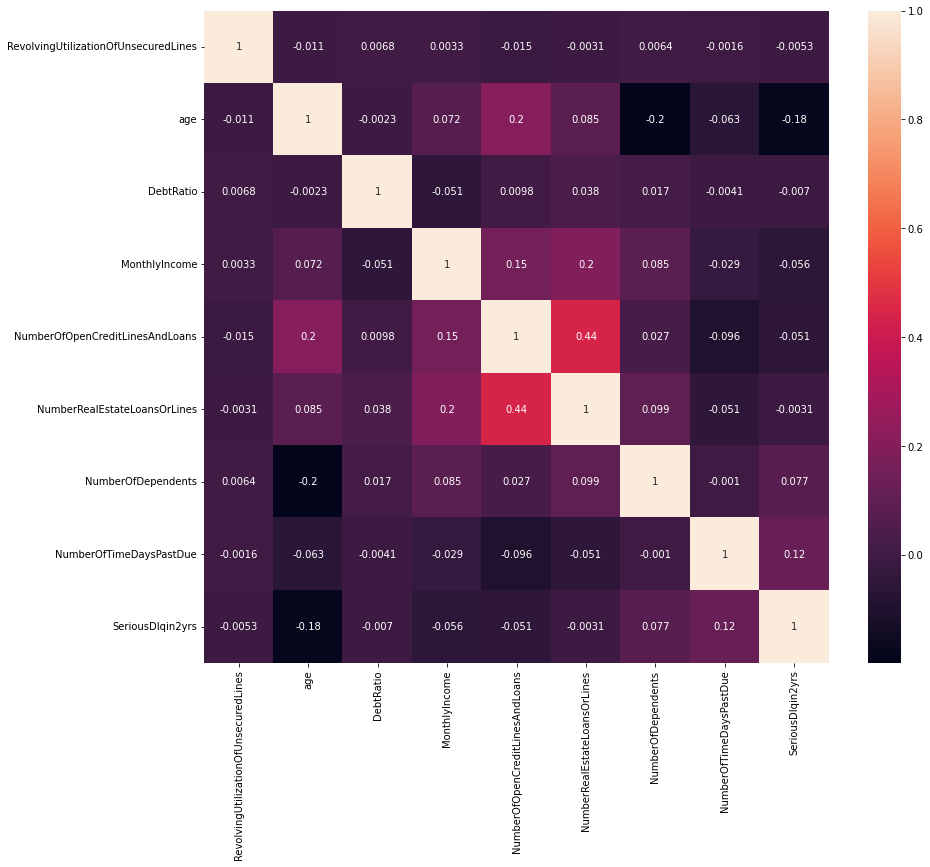

In [17]:
plt.figure(figsize=(14,12))
sns.heatmap(train_df.corr(), annot=True, fmt=".2g");

#### Separate datasets to features and target

In [18]:
X_train, y_train = train_df.drop(target_name, axis=1), train_df[target_name]
X_test, y_test = test_df.drop(target_name, axis=1), test_df[target_name]

## 3. Model - Random Forest Classifier

### Training Random Forest

The hyperparameters were chosen with cross-validation grid search.

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = (RandomForestClassifier(class_weight='balanced',
                                max_depth=30,
                                min_samples_leaf=2,
                                min_samples_split=100,
                                n_estimators=1200)
         .fit(X_train, y_train))

### Prediction Widget
Shows the prediction probability of the positive class (untrustworthy)

#### ⚠️  Ignore the setup code and go directly to the interactive widget

In [20]:
from ipywidgets import interact, IntSlider, FloatSlider, Layout

slider_setup = {'continuous_update': False,
                'style': {'description_width': 'initial'},
                'layout': Layout(width='50%')}

@interact(rev_util=FloatSlider(description='Revolving Utilization Of Unsecured Lines',
                               min=0, max=1, step=0.05, value=0, **slider_setup),
          age=IntSlider(description='Age',
                               min=18, max=91, value=27, **slider_setup),
          debt_ratio=FloatSlider(description='Debt Ratio',
                               min=0, max=1, step=0.05, value=0, **slider_setup),
          monthly_income=IntSlider(description='Monthly Income',
                                   min=0, max=10000, value=5000,  **slider_setup),
          number_of_open_credit_lines_and_loans=IntSlider(description='Number Of Open Credit Lines And Loans',
                                   min=0, max=11, value=0, **slider_setup),
          number_of_real_estate_loans_or_lines=IntSlider(description='Number Real Estate Loans Or Lines',
                                   min=0, max=11, value=0, **slider_setup),
          number_of_dependents=IntSlider(description='Number Of Dependents',
                                   min=0, max=8, value=0, **slider_setup),
          number_of_times_days_past_due=IntSlider(description='Number Of Time Days Past Due',
                                   min=0, max=31, value=0, **slider_setup))
def interactive_prediction(rev_util, age, debt_ratio, monthly_income,
                           number_of_open_credit_lines_and_loans,
                           number_of_real_estate_loans_or_lines,
                           number_of_dependents,
                           number_of_times_days_past_due):

    x = (rev_util, age, debt_ratio, monthly_income,
         number_of_open_credit_lines_and_loans,
         number_of_real_estate_loans_or_lines,
         number_of_dependents,
         number_of_times_days_past_due)

    y_pred_bad_prob = model.predict_proba([x])[0][1]

    _, ax = plt.subplots(1, figsize=(10, 1))
    plt.barh(' ', y_pred_bad_prob)
    plt.xlim(0, 1)
    plt.xlabel('Untrustworthiness indicator', fontsize=20)
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=15)
    plt.ylabel('', fontsize=20)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Revolving Utilization Of Un…

### Evaluation

In [21]:
print('Training dataset:')
print(classification_report(y_train, model.predict(X_train), target_names=class_names))

print('Test dataset:')
print(classification_report(y_test, model.predict(X_test), target_names=class_names))

Training dataset:
              precision    recall  f1-score   support

        Good       0.93      0.81      0.87     17590
         Bad       0.59      0.81      0.68      5809

    accuracy                           0.81     23399
   macro avg       0.76      0.81      0.77     23399
weighted avg       0.84      0.81      0.82     23399

Test dataset:
              precision    recall  f1-score   support

        Good       0.90      0.79      0.84      7481
         Bad       0.55      0.75      0.63      2548

    accuracy                           0.78     10029
   macro avg       0.73      0.77      0.74     10029
weighted avg       0.81      0.78      0.79     10029



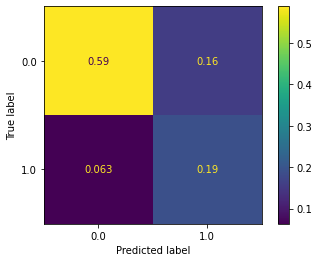

In [22]:
plot_confusion_matrix(model, X_test, y_test, normalize='all');

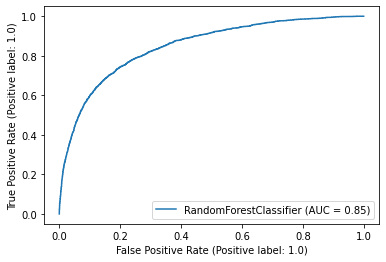

In [23]:
plot_roc_curve(model, X_test, y_test);

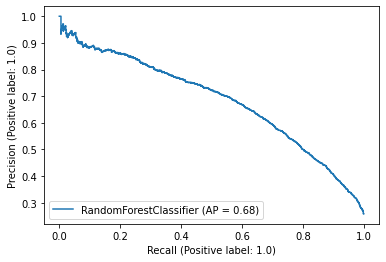

In [24]:
plot_precision_recall_curve(model, X_test, y_test);

### [OPTIONAL] Choosing threshold using cost matrix
- False Negative: 5 (giving risky loan)
- True Negative: -1 (giving loan to a trustworthy person)

⚠️ We shouldn't use the test dataset to choose the threshold, but we are doing so for this toy example; We should have had a validation dataset for that.

Best Threshod: 0.32418563250661026


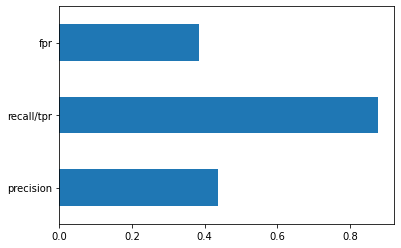

In [25]:
def get_best_threshold(model, X, y, cost_matrix):
    """TP, FN, FP, TN"""

    y_score = model.predict_proba(X)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y, y_score)

    num_pos_class = y.sum()
    num_neg_class = (1-y).sum()

    tp = recall * num_pos_class
    fp = (tp / precision) - tp
    tn = num_neg_class - fp
    fn = num_pos_class - tp
    
    assert ((tp + fp + tn + fn) == num_pos_class + num_neg_class).all()
    
    # acc = (tp + tn) / (num_pos_class + num_neg_class)

    confusion_matrix = np.stack([tp, fn, fp, tn])
    cost = cost_matrix @ confusion_matrix
    
    best_threshold_index = np.argmin(cost)
    best_threshold = thresholds[best_threshold_index]

    return best_threshold, {'precision': precision[best_threshold_index],
                            'recall/tpr': recall[best_threshold_index],
                            'fpr': fp[best_threshold_index]/num_neg_class}


#                      [TP, FN, FP, TN]
COST_MATRIX = np.array([0,  5,  0, -1])

best_threshod, metrics_ = get_best_threshold(model, X_test, y_test, COST_MATRIX)

print('Best Threshod:', best_threshod)
pd.Series(metrics_).plot(kind='barh');

### Setting the Prediction Function

In [26]:
# predict_fn = lambda X: model.predict_proba(X)[:, 1] > best_threshod
predict_fn = lambda X: model.predict(X)

## 4. Interpretable Machine Learning

### Reference:
- Molnar, Christoph. [Interpretable machine learning](https://christophm.github.io/interpretable-ml-book/). 2019.
- Lakkaraju, Hima. [Interpretability and Explainability in Machine Learning Course](https://interpretable-ml-class.github.io/). Harvard. 2019.

Choose one random row:

In [27]:
class_to_sample = 0  # change me!
assert class_to_sample in (0, 1)

np.random.seed(123456789)  # fix state for choosing random individual
idx = np.random.choice(y_test[y_test == class_to_sample].index)

print('Chosen Sample:', idx)
print('True class:', y_test[idx])
print('Prediction class:', predict_fn(X_test.loc[idx][None, :])[0] == 1)
print('Prediction probabilities:', model.predict_proba(X_test.loc[idx][None, :]))

X_test.loc[idx]

Chosen Sample: 19757
True class: 0.0
Prediction class: False
Prediction probabilities: [[0.98305291 0.01694709]]


RevolvingUtilizationOfUnsecuredLines       0.013858
age                                       67.000000
DebtRatio                                  0.004999
MonthlyIncome                           9000.000000
NumberOfOpenCreditLinesAndLoans            4.000000
NumberRealEstateLoansOrLines               0.000000
NumberOfDependents                         1.000000
NumberOfTimeDaysPastDue                    0.000000
Name: 19757, dtype: float64

### 4.1. Feature Importance

https://christophm.github.io/interpretable-ml-book/feature-importance.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

Random forest feature importance:

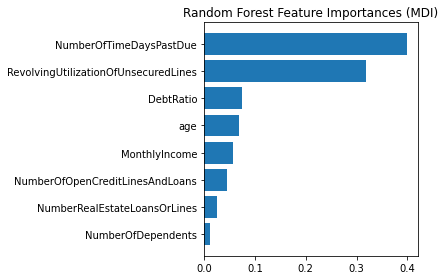

In [28]:
tree_feature_importances = model.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title('Random Forest Feature Importances (MDI)')
fig.tight_layout()
plt.show()

Permuation feature importance:

(The current implementation uses accuracy as metric)

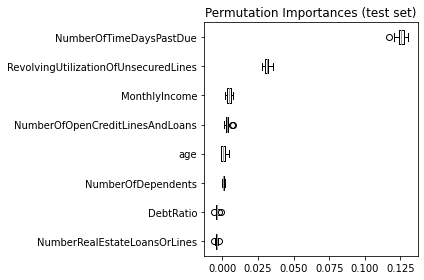

In [29]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title('Permutation Importances (test set)')
fig.tight_layout()
plt.show()

### 4.2. Partial Dependence Plot (PDP)

https://christophm.github.io/interpretable-ml-book/pdp.html

https://scikit-learn.org/stable/modules/partial_dependence.html

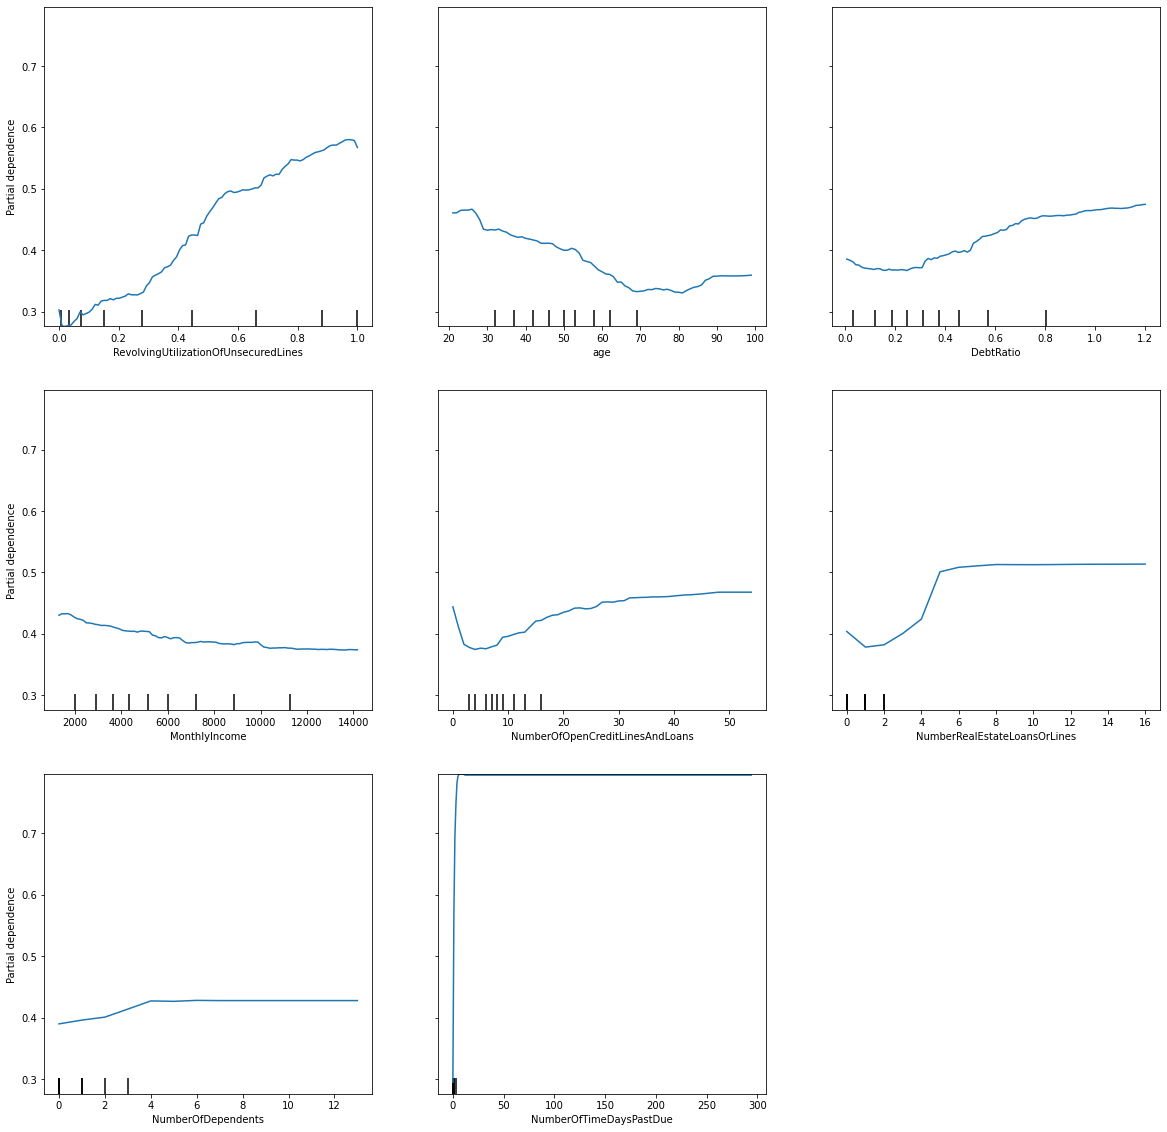

In [30]:
from sklearn.inspection import plot_partial_dependence

_, ax = plt.subplots(figsize=(20, 20))

plot_partial_dependence(model, X_test, X_test.columns, ax=ax);

### 4.3. LIME

https://christophm.github.io/interpretable-ml-book/lime.html

https://github.com/marcotcr/lime

https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html

In [31]:
import lime
import lime.lime_tabular

lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                        feature_names=feature_names,
                                                        class_names=class_names,
                                                        discretize_continuous=True)

In [32]:
exp = lime_explainer.explain_instance(X_test.loc[idx], model.predict_proba)

exp.show_in_notebook(show_table=True, show_all=False)

### 4.4. SHAP (SHapley Additive exPlanations)

https://christophm.github.io/interpretable-ml-book/shap.html

https://github.com/slundberg/shap

https://slundberg.github.io/shap/notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html

In [33]:
X_test_sample = X_test.sample(1000)

In [34]:
import shap

# sample from X_test, because otherwise it takes a lot of time to run
# and making sure that the choosed row is the last one
X_test_sample = X_test.sample(1000)
if idx in X_test_sample:
    X_test_sample = X_test_sample.drop(idx)
X_test_sample = X_test_sample.append(X_test.loc[idx])

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test_sample, check_additivity=False)

#### Visualize a single prediction

In [35]:
shap.initjs()  # Colab needs initjs in every cell

shap.force_plot(shap_explainer.expected_value[1], shap_values[1][-1,:], X_test_sample.iloc[-1,:])

#### Visualize many predictions

In [36]:
shap.initjs()  # Colab needs initjs in every cell

shap.force_plot(shap_explainer.expected_value[1], shap_values[1][-100:,:], X_test.iloc[-100:,:])

#### SHAP Summary Plot

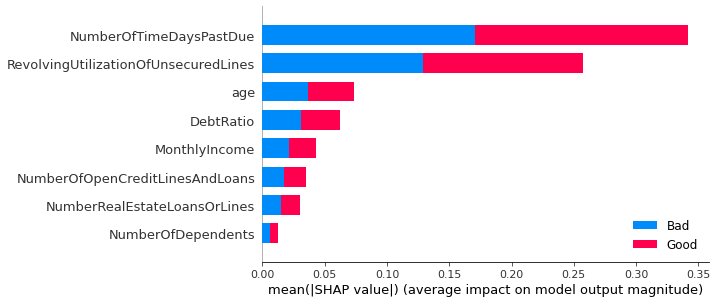

In [37]:
# mean absolute value of the SHAP values for each feature 
shap.summary_plot(shap_values, X_test, class_names=class_names)

#### SHAP Dependence Plots

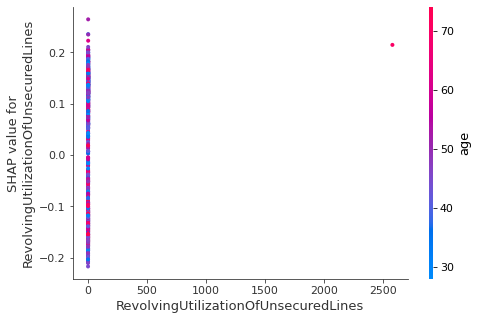

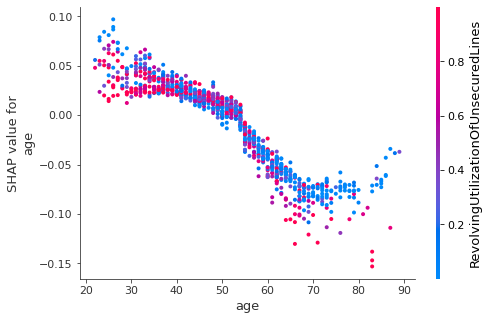

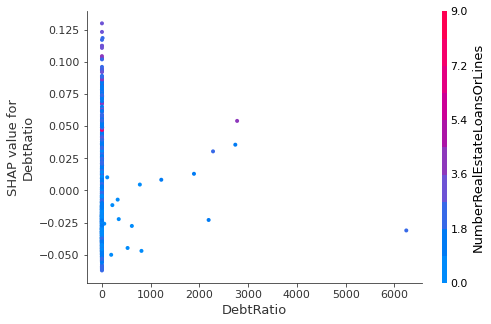

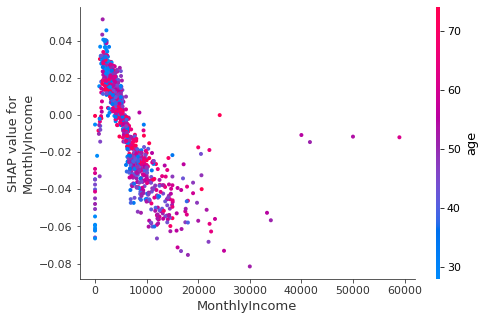

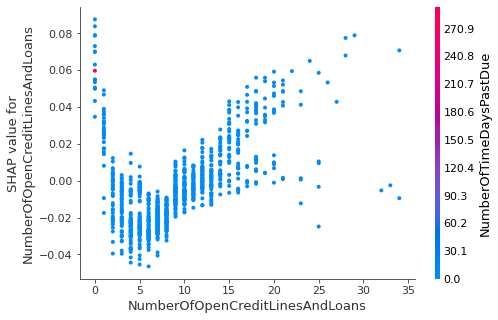

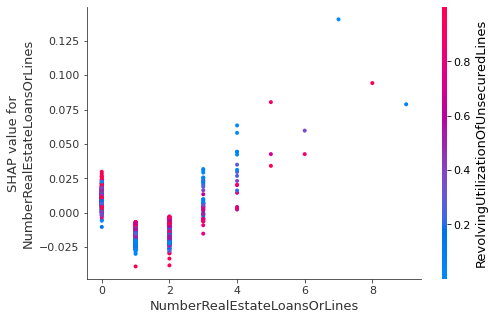

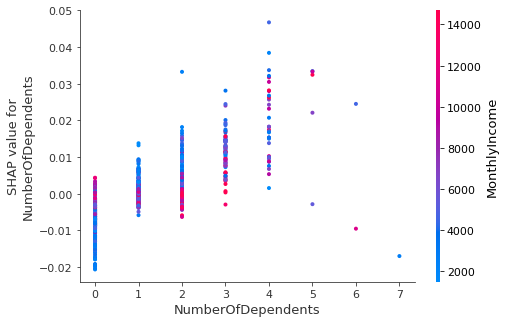

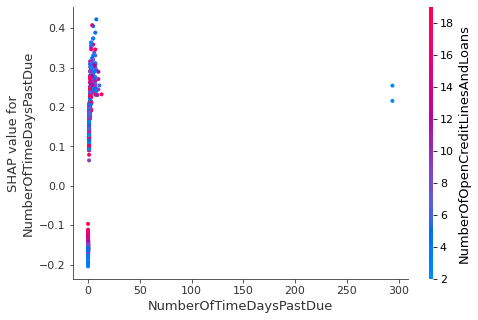

In [38]:
for name in X_test_sample.columns:
    shap.dependence_plot(name, shap_values[1], X_test_sample)

### 4.5. Anchor

https://docs.seldon.io/projects/alibi/en/stable/index.html

https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_tabular_adult.html

In [39]:
from alibi.explainers import AnchorTabular

In [40]:
anchor_explainer = (AnchorTabular(predict_fn, feature_names)
                    .fit(X_train.to_numpy()))

In [41]:
explanation = anchor_explainer.explain(X_test.loc[idx][None, :], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Anchor: NumberOfTimeDaysPastDue <= 0.00 AND RevolvingUtilizationOfUnsecuredLines <= 0.05
Precision: 1.00
Coverage: 0.22


### 4.6. Prototypes

https://christophm.github.io/interpretable-ml-book/proto.html

https://aix360.readthedocs.io/en/latest/die.html?protodash-explainer#protodash-explainer

https://nbviewer.jupyter.org/github/IBM/AIX360/blob/master/examples/tutorials/HELOC.ipynb

In [42]:
from aix360.algorithms.protodash import ProtodashExplainer

#### Normalize the data and chose a particular applicant, whose profile is displayed below

In [43]:
X_idx = X_test.loc[idx][None, :]
y_idx = predict_fn(X_idx)[None, :]
Xy_idx = np.hstack((X_idx, y_idx))

y_pred_train = predict_fn(X_train)
Xy_train = np.hstack((X_train,
                      y_pred_train[:, None]))

# Zy_train = np.hstack((minmax_scale(X_train, (-0.5, 0.5), axis=0),
#                       y_pred_train[:, None]))

Zy_train = Xy_train

Xy_train_by_prediction = Xy_train[y_pred_train == y_idx[0]]
Zy_train_by_prediction = Zy_train[y_pred_train == y_idx[0]]

#### Find similar applicants predicted as "bad" using the protodash explainer

In [44]:
prototype_explainer = ProtodashExplainer()

n_prototypes = 5

with suppress():
    weights, prototype_indices, set_values_obj_func = prototype_explainer.explain(Xy_idx,
                                                                                  Xy_train_by_prediction,
                                                                                  n_prototypes)

#### Display similar applicant user profiles and the extent to which they are similar to the chosen applicant as indicated by the last row in the table below labelled as "Weight"

In [45]:
prototype_df = pd.DataFrame.from_records(Xy_train_by_prediction[prototype_indices, 0:-1].astype('double'),
                                columns=list(feature_names))
prototype_classes = []
for prototype_index in prototype_indices:
    prototype_classes.append(class_names[int(Zy_train_by_prediction[prototype_index, -1])]) # Append class names

prototype_df[target_name] = prototype_classes
prototype_df['Weight'] = (np.around(weights, n_prototypes)
                          / np.sum(np.around(weights, n_prototypes))) # Calculate normalized importance weights
prototype_df = prototype_df.sort_values('Weight', ascending=False)

prototype_df.transpose()

,0,3,4,1,2
RevolvingUtilizationOfUnsecuredLines,0.0,0.018361,0.064155,18300.0,0.108889
age,37.0,63.0,52.0,45.0,48.0
DebtRatio,0.0,0.47938,0.003698,0.221582,25801.0
MonthlyIncome,4980.0,4000.0,699530.0,12500.0,0.0
NumberOfOpenCreditLinesAndLoans,2.0,30.0,11.0,5.0,4.0
NumberRealEstateLoansOrLines,0.0,1.0,2.0,1.0,1.0
NumberOfDependents,0.0,6.0,1.0,2.0,0.0
NumberOfTimeDaysPastDue,0.0,0.0,0.0,0.0,0.0
SeriousDlqin2yrs,Good,Good,Good,Good,Good
Weight,0.935653,0.063801,0.000441,0.000064,0.000041


In [46]:
X_test.loc[idx]

RevolvingUtilizationOfUnsecuredLines       0.013858
age                                       67.000000
DebtRatio                                  0.004999
MonthlyIncome                           9000.000000
NumberOfOpenCreditLinesAndLoans            4.000000
NumberRealEstateLoansOrLines               0.000000
NumberOfDependents                         1.000000
NumberOfTimeDaysPastDue                    0.000000
Name: 19757, dtype: float64

#### Compute how similar a feature of a prototypical user is to the chosen applicant.

Closer to 1 is similar.

In [47]:
EPS = 1e-10 # Small constant defined to eliminate divide-by-zero errors

Z_train_by_prediction_prototypes = Zy_train_by_prediction[prototype_indices, 0:-1] # Store chosen prototypes

log_feature_weights = (-np.abs(X_idx[0] - Z_train_by_prediction_prototypes)
                       / (np.std(Z_train_by_prediction_prototypes, axis=0) + EPS))

feature_weights = np.exp(log_feature_weights)

feature_weights_df = pd.DataFrame.from_records(np.around(feature_weights.astype('double'), 2),
                                               columns=feature_names)
feature_weights_df.transpose()

,0,1,2,3,4
RevolvingUtilizationOfUnsecuredLines,1.00,0.08,1.00,1.00,1.00
age,0.03,0.08,0.11,0.63,0.17
DebtRatio,1.00,1.00,0.08,1.00,1.00
MonthlyIncome,0.99,0.99,0.97,0.98,0.08
NumberOfOpenCreditLinesAndLoans,0.82,0.91,1.00,0.08,0.51
NumberRealEstateLoansOrLines,1.00,0.21,0.21,0.21,0.04
NumberOfDependents,0.64,0.64,0.64,0.11,1.00
NumberOfTimeDaysPastDue,1.00,1.00,1.00,1.00,1.00


### 4.7. Contrastive explanations

https://christophm.github.io/interpretable-ml-book/counterfactual.html

https://github.com/MarcelRobeer/ContrastiveExplanation

https://nbviewer.jupyter.org/github/MarcelRobeer/ContrastiveExplanation/blob/master/Contrastive%20explanation%20-%20example%20usage.ipynb

In [48]:
import contrastive_explanation as ce

In [49]:
# Create a domain mapper for the Pandas DataFrame
dm = ce.domain_mappers.DomainMapperTabular(X_train.to_numpy(),
                                           feature_names=feature_names,
                                           contrast_names=class_names)


# Create the contrastive explanation object (default is a Foil Tree explanator)
contrastive_explainer = ce.ContrastiveExplanation(dm)

In [50]:
# Explain the instance (sample) for the given model
explanation = contrastive_explainer.explain_instance_domain(model.predict_proba, X_test.loc[idx])

print(explanation)

The model predicted 'Good' instead of 'Bad' because 'NumberRealEstateLoansOrLines <= 1.247 and age > 63.602'


### 4.8. Global Surrogate - Decision Tree

https://christophm.github.io/interpretable-ml-book/global.html

In [51]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz

              precision    recall  f1-score   support

        Good       0.98      0.84      0.90      6534
         Bad       0.76      0.97      0.85      3495

    accuracy                           0.88     10029
   macro avg       0.87      0.90      0.88     10029
weighted avg       0.90      0.88      0.89     10029



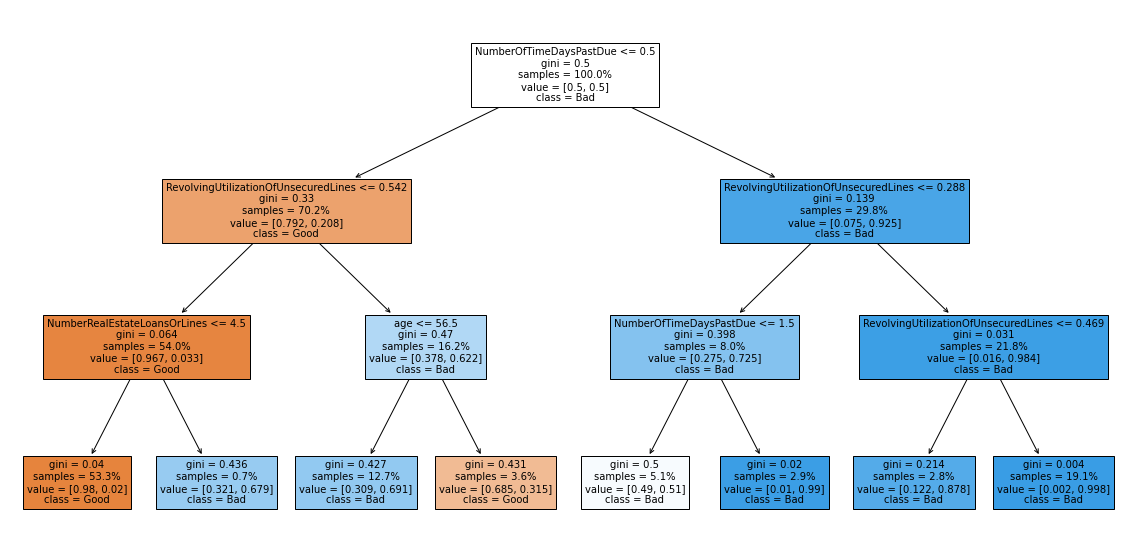

In [52]:
y_train_pred = predict_fn(X_train)
y_test_pred = predict_fn(X_test)

global_surrogate_model = (DecisionTreeClassifier(class_weight='balanced',
                                                 max_depth=3)
                          .fit(X_train, y_train_pred))

y_test_global_surrogate = global_surrogate_model.predict(X_test)

print(classification_report(y_test_pred, y_test_global_surrogate, target_names=class_names))


_, ax = plt.subplots(figsize=(20, 10))

plot_tree(global_surrogate_model,
          feature_names=feature_names, class_names=class_names,
          filled=True, proportion=True, fontsize=10, ax=ax);

### 4.9. Interpretable Model - CORELS

https://corels.eecs.harvard.edu/

https://christophm.github.io/interpretable-ml-book/rules.html

Discretize features into binary variables

In [53]:
from sklearn.preprocessing import KBinsDiscretizer

# we let the discretization run automatically
# we probably could come up with better way to do so with some feature engineering
kbins_disc = KBinsDiscretizer(n_bins=10, encode='onehot-dense')
X_train_binarized = kbins_disc.fit_transform(X_train)

binarized_features= [f'{feature}_[{rh:.2f},{lh:.2f})'
                     for feature, bin_edges in zip(X_train.columns, kbins_disc.bin_edges_)
                     for rh, lh in zip(bin_edges[:-1], bin_edges[1:])]

X_train_binarized = pd.DataFrame(X_train_binarized,
                                 columns=binarized_features, index=X_train.index)

X_test_binarized = kbins_disc.transform(X_test)
X_test_binarized = pd.DataFrame(X_test_binarized,
                                columns=binarized_features, index=X_test.index)

CORELS Model

In [54]:
from corels import CorelsClassifier

corels_model = (CorelsClassifier()
                .fit(X_train_binarized, y_train, binarized_features))

print()
y_pred_corels = corels_model.predict(X_test_binarized)
print(classification_report(y_test, y_pred_corels))

RULELIST:
if [NumberOfTimeDaysPastDue_[2.00,294.00) && not RevolvingUtilizationOfUnsecuredLines_[0.14,0.26)]:
  prediction = True
else 
  prediction = False

              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      7481
         1.0       0.72      0.45      0.55      2548

    accuracy                           0.82     10029
   macro avg       0.78      0.69      0.72     10029
weighted avg       0.80      0.82      0.80     10029

